In [1]:
import numpy as np
import scipy.linalg
import networkx as nx
import matplotlib.pyplot as plt
import math
from tqdm import tqdm

from scipy.linalg import expm
from scipy.linalg import null_space

from general_graph_utils import *

## Oscillations on 3-vertex graph

Here, we confirm the results published in Barato, Seifert 2017 for oscillations in a unicyclic network. 

In [2]:
def affinity(k12,k21,k23,k32,k31,k13):
    aff = np.log((k12*k23*k31)/(k13*k32*k21))
    return aff

In [3]:
# Transition rate matrix W
def transition_matrix(k12,k21,k23,k32,k31,k13):
    W = np.array([
        [-k12 - k13, k21, k31],  # Transition rates from E1
        [k12, -k21 - k23, k32],  # Transition rates from E2
        [k13, k23, -k31 - k32],  # Transition rates from E3
    ])
    return W

In [4]:
# Function to compute the correlation function C(t)
def correlation_function(t, W):
    exp_Wt = expm(W * t) # Compute the matrix exponential e^(Wt)
    p = [1,0,0]
    return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0

All rates = 1.0

In [5]:
k12, k21 = 1.0, 1.0  # Rates between E1 and E2
k23, k32 = 1.0, 1.0  # Rates between E2 and E3
k31, k13 = 1.0, 1.0  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 0.0
eigenvalues: [-3.0000000e+00+0.j  4.4408921e-16+0.j -3.0000000e+00+0.j]
decay time: 0.33333333333333337
period: inf
number coherent oscillations: 0.0


/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_83884/2096770409.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  omega = (2*math.pi)/x_i


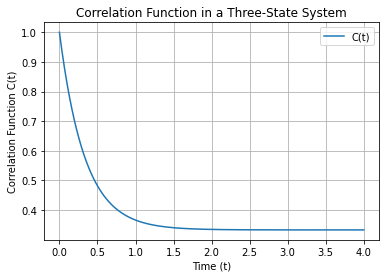

In [6]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

$\mathcal{A}$ = 1.0

In [7]:
k12, k21 = 1.0, 2.0  # Rates between E1 and E2
k23, k32 = 1.5, 1.0  # Rates between E2 and E3
k31, k13 = 2.0, 0.5  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(np.sort(eigvals)))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 1.0986122886681098
eigenvalues: [-4.5000000e+00+0.j -3.5000000e+00+0.j  4.4408921e-16+0.j]
decay time: 0.2857142857142857
period: inf
number coherent oscillations: 0.0


/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_83884/809545786.py:21: RuntimeWarning: divide by zero encountered in double_scalars
  omega = (2*math.pi)/x_i


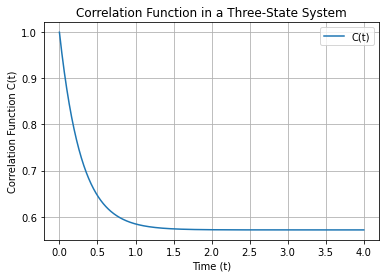

In [8]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

Oscillatory transition rates

In [9]:
# Oscillatory transition rates
k12, k21 = 1.0, 0.5  # Rates between E1 and E2
k23, k32 = 1.5, 0.2  # Rates between E2 and E3
k31, k13 = 2.0, 0.1  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 5.703782474656201
eigenvalues: [-3.18595413e-16+0.j         -2.65000000e+00+0.99874922j
 -2.65000000e+00-0.99874922j]
decay time: 0.3773584905660376
period: 6.291054045776005
number coherent oscillations: 0.5920119255341094


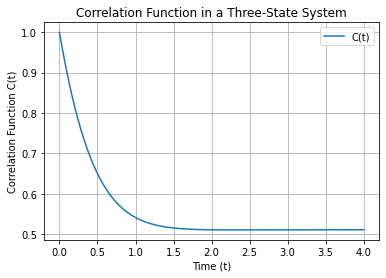

In [10]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

Eigenvalues complex

In [11]:
# Oscillatory transition rates
k13, k12, k23, k21, k31, k32 = 0.10536, 0.00158, 0.00805, 0.06794, 0.03089, 0.08335

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(eigvals[1].imag)
x_r = np.abs(eigvals[1].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 50, 500)  # time from 0 to 50 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: -7.325527183964429
eigenvalues: [-1.48585000e-01+0.05398063j -1.48585000e-01-0.05398063j
  2.38637456e-17+0.j        ]
decay time: 6.730154457044786
period: 116.39703431960048
number coherent oscillations: 0.5706671345841586


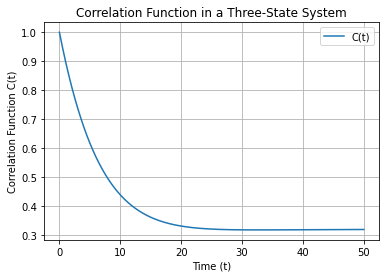

In [12]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

In [13]:
# Oscillatory transition rates
k13, k12, k23, k21, k31, k32 = 1.160000e-03, 1.330766e+01, 8.319220e+00, 3.330000e-03, 1.046221e+01, 1.978970e+00

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 1.5, 500)  # time from 0 to 1.5 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 18.836219768636184
eigenvalues: [ 3.58090794e-15+0.j         -1.70362750e+01+8.55151942j
 -1.70362750e+01-8.55151942j]
decay time: 0.058698277645788215
period: 0.734744903218277
number coherent oscillations: 0.7884760776858771


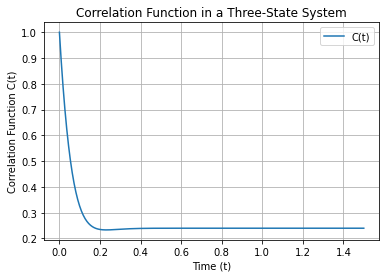

In [14]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

Totally away from equilibrium (unidirectional)

In [15]:
# Oscillatory transition rates
k12, k21 = 2.0, 0  # Rates between E1 and E2
k23, k32 = 2.0, 0  # Rates between E2 and E3
k31, k13 = 2.0, 0  # Rates between E3 and E1

# force
#print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 4, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

eigenvalues: [-3.00000000e+00+1.73205081j -3.00000000e+00-1.73205081j
 -6.48686449e-17+0.j        ]
decay time: 0.3333333333333333
period: 3.627598728468435
number coherent oscillations: 0.906899682117109


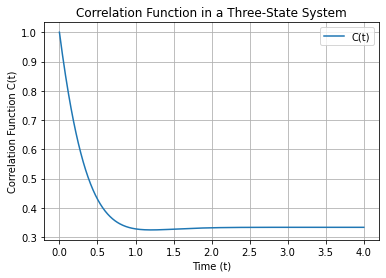

In [16]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

In [17]:
# Oscillatory transition rates
k12, k21 = 20.0, 1.0  # Rates between E1 and E2
k23, k32 = 20.0, 1.0  # Rates between E2 and E3
k31, k13 = 20.0, 1.0  # Rates between E3 and E1

# force
print("force: " + str(affinity(k12,k21,k23,k32,k31,k13)))

# eigenvalues of W
W = transition_matrix(k12,k21,k23,k32,k31,k13)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 1, 500)  # time from 0 to 1 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function(t, W) for t in times]

force: 8.987196820661973
eigenvalues: [-3.49536271e-15 +0.j         -3.15000000e+01+16.45448267j
 -3.15000000e+01-16.45448267j]
decay time: 0.03174603174603172
period: 0.3818524977335192
number coherent oscillations: 0.8205282838202415


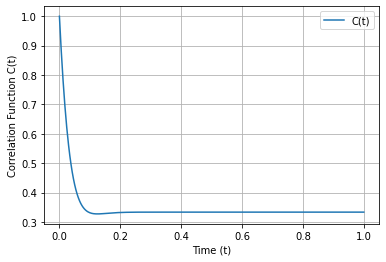

In [18]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
#plt.title('Correlation Function in a Three-State System')
plt.legend()
plt.grid()
plt.show()

What parameter sets give you complex eigenvalues?

In [19]:
G = nx.DiGraph()
G_size = 3
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,3)
G.add_edge(3,1)
G.add_edge(2,3)
G.add_edge(3,2)
G.add_edge(1,2)
G.add_edge(2,1)


G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(1, 3)
G_ud.add_edge(3, 1)

In [20]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [21]:
label_dict, label_list = get_labels(G)

In [22]:
label_dict

{(1, 3): 98.91588,
 (1, 2): 44.16268,
 (2, 3): 0.00257,
 (2, 1): 974.61241,
 (3, 1): 4.39008,
 (3, 2): 262.15004}

In [23]:
all_labels = np.zeros((1000,6))
all_eigvals_real = np.zeros((1000,3))
all_eigvals_complex = np.zeros((1000,3))
all_affinities = np.zeros((1000,1))

In [24]:
for i in range(1000):
    label_dict, label_list = get_labels(G)
    all_labels[i] = label_list
    cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f, products_b, cycle_list)
    all_affinities[i] = total_affinities
    L = Laplacian_all(edge_list,label_list,node_list)
    eigvals, eigvecs = scipy.linalg.eig(L)
    eigvals_sorted = np.sort(eigvals)
    all_eigvals_real[i] = eigvals_sorted.real
    all_eigvals_complex[i] = eigvals_sorted.imag

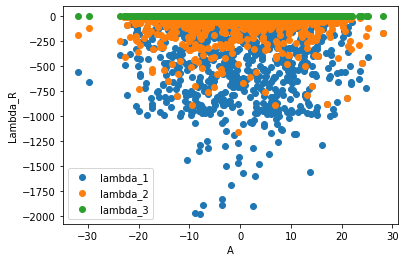

In [25]:
plt.scatter(all_affinities, all_eigvals_real[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_real[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_real[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_R')
plt.legend()

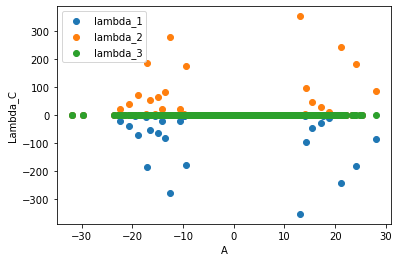

In [26]:
plt.scatter(all_affinities, all_eigvals_complex[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_complex[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_complex[:,2], label='lambda_3')
plt.xlabel('A')
plt.ylabel('Lambda_C')
plt.legend()

Find a parameter set that has complex eigenvalues and a particular affinity.

In [27]:
indices = np.nonzero(all_eigvals_complex)

In [28]:
all_affinities[indices[0][0]]

array([21.14227311])

In [29]:
all_eigvals_complex[indices[0][0]]

array([-243.11620993,  243.11620993,    0.        ])

In [30]:
all_labels[indices[0][0],:]

array([1.3520000e-02, 1.2231538e+02, 5.7633277e+02, 3.1120000e-01,
       9.2148503e+02, 1.0154390e+01])

In [31]:
label_dict # just to see the order of rates

{(1, 3): 24.14439,
 (1, 2): 0.01535,
 (2, 3): 1.90101,
 (2, 1): 462.47389,
 (3, 1): 9.40606,
 (3, 2): 917.37692}

Five-state graph

In [32]:
k12,k21,k23,k32,k34,k43,k45,k54,k15,k51 = 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0

In [33]:
def affinity5(k12,k21,k23,k32,k34,k43,k45,k54,k15,k51):
    aff = np.log((k12*k23*k34*k45*k51)/(k15*k54*k43*k32*k21))
    return aff

In [34]:
# Transition rate matrix W
def transition_matrix5(k12,k21,k23,k32,k34,k43,k45,k54,k15,k51):
    W = np.array([
        [-k12-k15,k21,0,0,k51],  # Transition rates from E1
        [k12,-k21-k23,k32,0,0],  # Transition rates from E2
        [0,k23,-k32-k34,k43,0],  # Transition rates from E3
        [0,0,k34,-k43-k45,k54],  # Transition rates from E4
        [k15,0,0,k45,-k51-k54],  # Transition rates from E5
    ])
    return W

In [35]:
# Function to compute the correlation function C(t)
def correlation_function5(t, W):
    exp_Wt = expm(W * t) # Compute the matrix exponential e^(Wt)
    p = [1,0,0,0,0]
    return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0

In [36]:
# Oscillatory transition rates

k12, k23, k34, k45, k51 = 0.0, 0.0, 0.0, 0.0, 0.0
k21, k32, k43, k54, k15 = 2.0, 2.0, 2.0, 2.0, 2.0

#k12, k15, k21, k23, k32, k34, k43, k45, k54, k51 = 6.6867835e+02, 1.2356196e+02, 3.0750714e+02, 4.6800000e-03, 1.0429112e+02, 1.2768300e+01, 1.0017890e+01, 3.5640000e-01, 5.3848260e+01, 1.6982000e-01

# force
print("force: " + str(affinity5(k12,k21,k23,k32,k34,k43,k45,k54,k15,k51)))

# eigenvalues of W
W = transition_matrix5(k12,k21,k23,k32,k34,k43,k45,k54,k15,k51)
eigvals, eigvecs = scipy.linalg.eig(W)
print("eigenvalues: " + str(eigvals))

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(0, 10, 500)  # time from 0 to 4 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function5(t, W) for t in times]

force: -inf
eigenvalues: [-3.61803399e+00+1.1755705j  -3.61803399e+00-1.1755705j
 -1.38196601e+00+1.90211303j -1.38196601e+00-1.90211303j
 -3.05992170e-16+0.j        ]
decay time: 0.7236067977499785
period: 3.303265999194125
number coherent oscillations: 2.1620156649430227


/var/folders/ch/f1rl6h5x4fx2wbg2_f5bj5dw0000gn/T/ipykernel_83884/401400925.py:2: RuntimeWarning: divide by zero encountered in log
  aff = np.log((k12*k23*k34*k45*k51)/(k15*k54*k43*k32*k21))


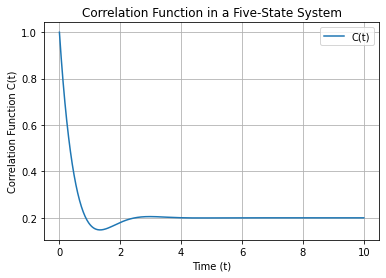

In [37]:
plt.plot(times, correlation_values, label='C(t)')
plt.xlabel('Time (t)')
plt.ylabel('Correlation Function C(t)')
plt.title('Correlation Function in a Five-State System')
plt.legend()
plt.grid()
plt.show()

What parameter sets give you complex eigenvalues?

In [38]:
G = nx.DiGraph()
G_size = 5
nodes = np.arange(1,G_size+1,step=1)
G.add_nodes_from(nodes)

G.add_edge(1,2)
G.add_edge(2,1)
G.add_edge(2,3)
G.add_edge(3,2)
G.add_edge(4,3)
G.add_edge(3,4)
G.add_edge(4,5)
G.add_edge(5,4)
G.add_edge(5,1)
G.add_edge(1,5)

G_ud = nx.Graph()
G_ud.add_node(1)
G_ud.add_node(2)
G_ud.add_node(3)
G_ud.add_edge(3, 2)
G_ud.add_edge(2, 3)
G_ud.add_edge(1, 2)
G_ud.add_edge(2, 1)
G_ud.add_edge(4,3)
G_ud.add_edge(3,4)
G_ud.add_edge(4,5)
G_ud.add_edge(5,4)
G_ud.add_edge(5,1)
G_ud.add_edge(1,5)

In [39]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [40]:
label_dict, label_list = get_labels(G)

In [55]:
label_dict

{(1, 2): 0.0044,
 (1, 5): 214.78036,
 (2, 1): 0.00146,
 (2, 3): 183.57177,
 (3, 2): 966.3961,
 (3, 4): 73.63904,
 (4, 3): 134.72543,
 (4, 5): 3.82045,
 (5, 4): 0.63436,
 (5, 1): 0.00189}

In [56]:
all_labels = np.zeros((10,10))
all_eigvals_real = np.zeros((10,5))
all_eigvals_complex = np.zeros((10,5))
all_affinities = np.zeros((10))

In [57]:
for i in range(10):
    label_dict, label_list = get_labels(G)
    all_labels[i] = label_list
    cycle_edges_forward,cycle_edges_backward,cycle_labels_forward,cycle_labels_backward = get_cycle_labels_edges(cycle_list,label_dict)
    products_f, products_b = calculate_cycle_products(cycle_labels_forward,cycle_labels_backward)
    total_affinities = calculate_affinities(products_f, products_b, cycle_list)
    all_affinities[i] = total_affinities
    print(total_affinities)
    L = Laplacian_all(edge_list,label_list,node_list)
    eigvals, eigvecs = scipy.linalg.eig(L)
    eigvals_sorted = np.sort(eigvals)
    all_eigvals_real[i] = eigvals_sorted.real
    print(eigvals_sorted.real)
    all_eigvals_complex[i] = eigvals_sorted.imag
    print(eigvals_sorted.imag)

[22.7662136]
[-3.64606463e+02 -7.90022282e+00 -3.84110191e+00 -3.84110191e+00
 -4.44089210e-16]
[ 0.          0.         -1.64946913  1.64946913  0.        ]
[-14.71319614]
[-7.72247432e+02 -8.61738101e+01 -2.08480139e+01 -4.37263889e-01
 -7.80885470e-17]
[0. 0. 0. 0. 0.]
[5.89122207]
[-7.88200360e+02 -4.23625154e+02 -5.03466983e+01 -4.67980805e+00
 -2.60840655e-14]
[0. 0. 0. 0. 0.]
[-9.24319809]
[-1.09739562e+03 -9.23147193e+00 -6.02177313e+00 -5.47603114e-02
 -4.10430769e-14]
[0. 0. 0. 0. 0.]
[-30.14542088]
[-4.46617084e+01 -2.76446926e+01 -8.59827951e+00 -8.59827951e+00
 -1.75994441e-15]
[ 0.          0.         -1.04457832  1.04457832  0.        ]
[-3.59925182]
[-2.62612523e+02 -1.71264059e+02 -1.22213933e+02 -1.69159512e+00
  2.61160889e-15]
[0. 0. 0. 0. 0.]
[4.67974106]
[-7.50475240e+02 -4.44160372e+01 -2.55886275e+01 -1.35749547e-02
  2.34753596e-13]
[0. 0. 0. 0. 0.]
[-8.213512]
[-4.37147028e+02 -1.72908114e+02 -4.75582657e-01 -8.43250320e-02
  1.49577186e-16]
[0. 0. 0. 0. 0.]
[

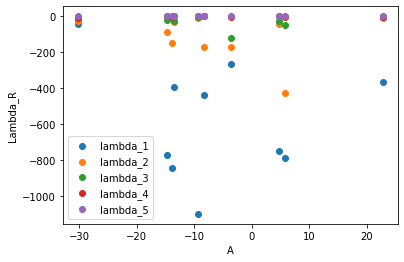

In [58]:
plt.scatter(all_affinities, all_eigvals_real[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_real[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_real[:,2], label='lambda_3')
plt.scatter(all_affinities, all_eigvals_real[:,3], label='lambda_4')
plt.scatter(all_affinities, all_eigvals_real[:,4], label='lambda_5')
plt.xlabel('A')
plt.ylabel('Lambda_R')
plt.legend()

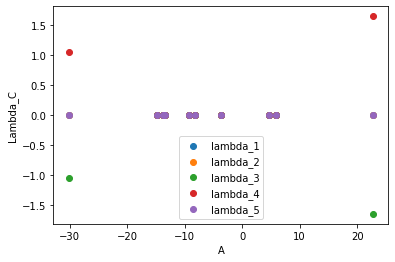

In [59]:
plt.scatter(all_affinities, all_eigvals_complex[:,0], label='lambda_1')
plt.scatter(all_affinities, all_eigvals_complex[:,1], label='lambda_2')
plt.scatter(all_affinities, all_eigvals_complex[:,2], label='lambda_3')
plt.scatter(all_affinities, all_eigvals_complex[:,3], label='lambda_4')
plt.scatter(all_affinities, all_eigvals_complex[:,4], label='lambda_5')
plt.xlabel('A')
plt.ylabel('Lambda_C')
plt.legend()

Find a parameter set that has complex eigenvalues and a particular affinity.

In [60]:
np.nonzero(all_eigvals_complex)

(array([0, 0, 4, 4]), array([2, 3, 2, 3]))

In [61]:
all_affinities[4]

-30.14542087806029

In [62]:
all_eigvals_complex[4]

array([ 0.        ,  0.        , -1.04457832,  1.04457832,  0.        ])

In [63]:
all_labels[4,:]

array([1.300000e-03, 7.836460e+00, 3.012700e-01, 6.310000e-03,
       2.751551e+01, 3.670000e-03, 6.978220e+00, 2.486000e-02,
       4.464728e+01, 2.188080e+00])

In [64]:
label_dict # just to see the order of rates
#k12, k15, k21, k23, k32, k34, k43, k45, k54, k51 = 

{(1, 2): 1.48874,
 (1, 5): 28.65444,
 (2, 1): 0.31536,
 (2, 3): 0.41655,
 (3, 2): 24.72496,
 (3, 4): 0.02524,
 (4, 3): 0.00595,
 (4, 5): 0.01449,
 (5, 4): 391.91423,
 (5, 1): 3.43589}

More formal workflow

In [65]:
def unicycle_graph(n):
    """
    Generates a reversible unicyclic linear framework graph of size n.
    
    Parameters
    ----------
    n : integer
        the size (or number of vertices) of the graph
    
    Returns
    -------
    G : NetworkX DiGraph object
        directed graph
    
    G_ud : NetworkX Graph object
        undirected graph
    """
    
    G = nx.DiGraph()
    G_ud = nx.Graph()
    
    # determine the number of nodes in G
    G_size = n
    
    # add nodes to G and G_ud
    nodes = np.arange(1,G_size+1,step=1)
    G.add_nodes_from(nodes)
    G_ud.add_nodes_from(nodes)
    
    for i in range(2,G_size+1):
        u = i-1
        v = i
        G.add_edge(u,v)
        G.add_edge(v,u)
        G_ud.add_edge(u,v)
        
    G.add_edge(G_size,1)
    G.add_edge(1,G_size)
    G_ud.add_edge(1,G_size)
    
    return G, G_ud

In [66]:
G, G_ud = unicycle_graph(5)

In [67]:
nodes = list(G.nodes())

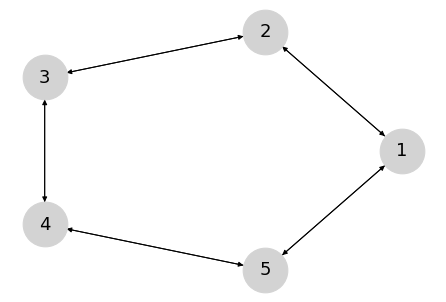

In [68]:
node_labels = {}

for node in nodes:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=2000, node_color = 'lightgray', font_size=18, font_color='black', font_family='sans-serif')

In [69]:
node_list = get_nodes(G)
num_nodes = G_size
edge_list = get_edges(G)

# not needed for 3-cycle graph but we need the data structures
cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

In [70]:
cycle_list

[[2, 3, 4, 5, 1]]

In [71]:
np.array(G.edges)

array([[1, 2],
       [1, 5],
       [2, 1],
       [2, 3],
       [3, 2],
       [3, 4],
       [4, 3],
       [4, 5],
       [5, 4],
       [5, 1]])

In [72]:
edge_tracker = []
edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = 2.0
    edge_labels_forward = np.append(edge_labels_forward, 2.0)
    
    G[v][u]['weight'] = 1.0
    edge_labels_backward = np.append(edge_labels_backward, 1.0)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = 2.0
edge_labels_forward = np.append(edge_labels_forward, 2.0)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = 1.0
edge_labels_backward = np.append(edge_labels_backward, 1.0)

In [73]:
label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}
label_dict

{(1, 2): 2.0,
 (1, 5): 1.0,
 (2, 1): 1.0,
 (2, 3): 2.0,
 (3, 2): 1.0,
 (3, 4): 2.0,
 (4, 3): 1.0,
 (4, 5): 2.0,
 (5, 4): 1.0,
 (5, 1): 2.0}

In [74]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [75]:
W = Laplacian_all(edge_list,label_list,node_list)
W

array([[-3.,  2.,  0.,  0.,  1.],
       [ 1., -3.,  2.,  0.,  0.],
       [ 0.,  1., -3.,  2.,  0.],
       [ 0.,  0.,  1., -3.,  2.],
       [ 2.,  0.,  0.,  1., -3.]], dtype=float128)

In [76]:
affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
affinity

3.4657359027997265

In [77]:
p = np.zeros((1,10))
p[0] = 1

In [78]:
# Function to compute the correlation function C(t)
def correlation_function_general(t, W, n):
    exp_Wt = expm(W * t) # Compute the matrix exponential e^(Wt)
    #p = np.zeros((1,n))
    #p[0] = 1
    #return (exp_Wt[0]*p)[0] # e^(Wt)[11] Prob of being in 1 at time t given was in 1 at time 0
    return exp_Wt[0][0]

Checks

In [79]:
for i in range(num_nodes-1):
    print(cycle_list[0][i], cycle_list[0][i+1])
print(cycle_list[0][-1], cycle_list[0][0])

2 3
3 4
4 5
5 1
1 2


In [80]:
np.prod(edge_labels_forward)

32.0

In [81]:
2**100

1267650600228229401496703205376

In [82]:
np.prod(edge_labels_backward)

1.0

Recreate Barato Seifert 2017

In [168]:
G, G_ud = unicycle_graph(100)

In [169]:
node_list = get_nodes(G)
num_nodes = len(node_list)
edge_list = get_edges(G)

cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

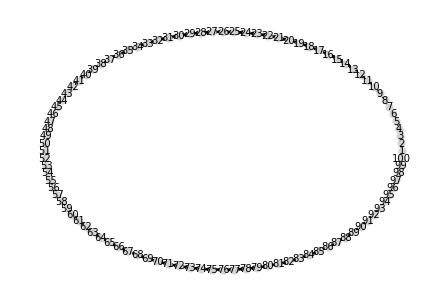

In [170]:
node_labels = {}

for node in node_list:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=50, node_color = 'lightgray', font_size=10, font_color='black', font_family='sans-serif')

In [171]:
edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = 7.4
    edge_labels_forward = np.append(edge_labels_forward, 7.4)
    
    G[v][u]['weight'] = 1.0
    edge_labels_backward = np.append(edge_labels_backward, 1.0)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = 7.4
edge_labels_forward = np.append(edge_labels_forward, 7.4)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = 1.0
edge_labels_backward = np.append(edge_labels_backward, 1.0)

In [172]:
label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}

In [173]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [174]:
W = Laplacian_all(edge_list,label_list,node_list)

In [175]:
affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
affinity

200.14800002101242

In [191]:
# eigenvalues of W
W = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(W)

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

print(x_i, x_r)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(100, 250, 500)  # time from 0 to 1.5 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function_general(t, W, n=100) for t in times]

0.40185932498760557 0.016575481202521627
decay time: 60.330073545488986
period: 15.63528557505385
number coherent oscillations: 38.08270443954152


In [244]:
times = np.linspace(100, 250, 500)
exp_values = [math.exp(-(x_i/x_r)*t) for t in times]

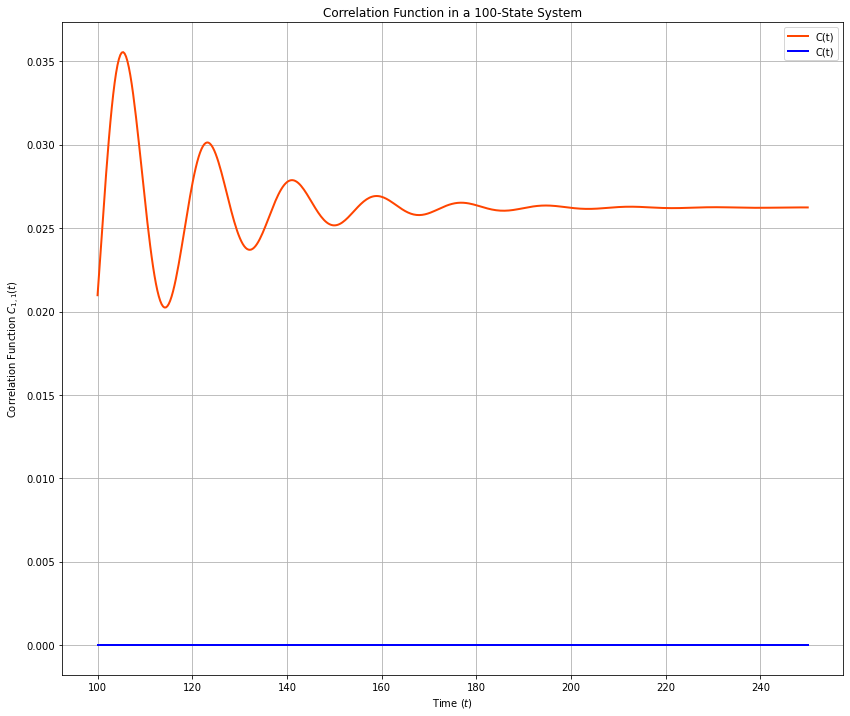

In [245]:
fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.plot(times, exp_values, color = "blue", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a 100-State System')
plt.legend()
plt.grid()
plt.show()

What's the minimum number of states to get reasonable oscillations?

In [83]:
x = 35
G, G_ud = unicycle_graph(x)

In [84]:
node_list = get_nodes(G)
num_nodes = len(node_list)
edge_list = get_edges(G)

cycle_list = get_cycles(G_ud)
num_cycles = len(cycle_list)

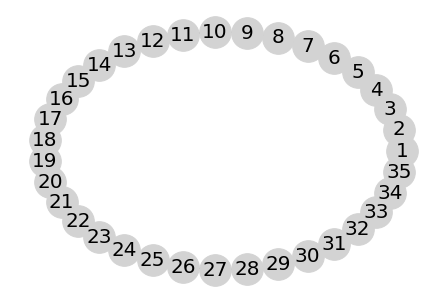

In [85]:
node_labels = {}

for node in node_list:
    node_labels[node] = str(node)

nx.draw(G, pos=nx.circular_layout(G), labels=node_labels, with_labels=True,node_size=1000, node_color = 'lightgray', font_size=20, font_color='black', font_family='sans-serif')

In [86]:
edge_labels_forward = np.array([])
edge_labels_backward = np.array([])

for i in range(num_nodes-1):
    u = cycle_list[0][i]
    v = cycle_list[0][i+1]
    
    G[u][v]['weight'] = 7.4
    edge_labels_forward = np.append(edge_labels_forward, 2.0)
    
    G[v][u]['weight'] = 1.0
    edge_labels_backward = np.append(edge_labels_backward, 1.0)

G[cycle_list[0][-1]][cycle_list[0][0]]['weight'] = 2.0
edge_labels_forward = np.append(edge_labels_forward, 2.0)
G[cycle_list[0][0]][cycle_list[0][-1]]['weight'] = 1.0
edge_labels_backward = np.append(edge_labels_backward, 1.0)

In [87]:
label_dict = {e: G[e[0]][e[1]]['weight'] for e in G.edges}

In [88]:
label_list = np.fromiter(label_dict.values(), dtype=float)

In [89]:
W = Laplacian_all(edge_list,label_list,node_list)

In [90]:
affinity = np.log(np.prod(edge_labels_forward)/np.prod(edge_labels_backward))
affinity

24.260151319598087

In [91]:
# eigenvalues of W
W = Laplacian_all(edge_list,label_list,node_list)
eigvals, eigvecs = scipy.linalg.eig(W)

x_i = np.abs(np.sort(eigvals)[-2].imag)
x_r = np.abs(np.sort(eigvals)[-2].real)

print(x_i, x_r)

# decay time
tau = 1/x_r
print("decay time: " + str(tau))

# oscillation period
omega = (2*math.pi)/x_i
print("period: " + str(omega))

# number of coherent oscillations
R = x_i/x_r
print("number coherent oscillations: " + str(R/2*math.pi))

# Time points for the plot
times = np.linspace(10, 60, 500)  # time from 0 to 1.5 with 500 points
# Compute C(t) for each time point
correlation_values = [correlation_function_general(t, W, n=100) for t in times]

1.054836338088258 0.14503787884847413
decay time: 6.894750584740232
period: 5.95654992182671
number coherent oscillations: 11.424140082535736


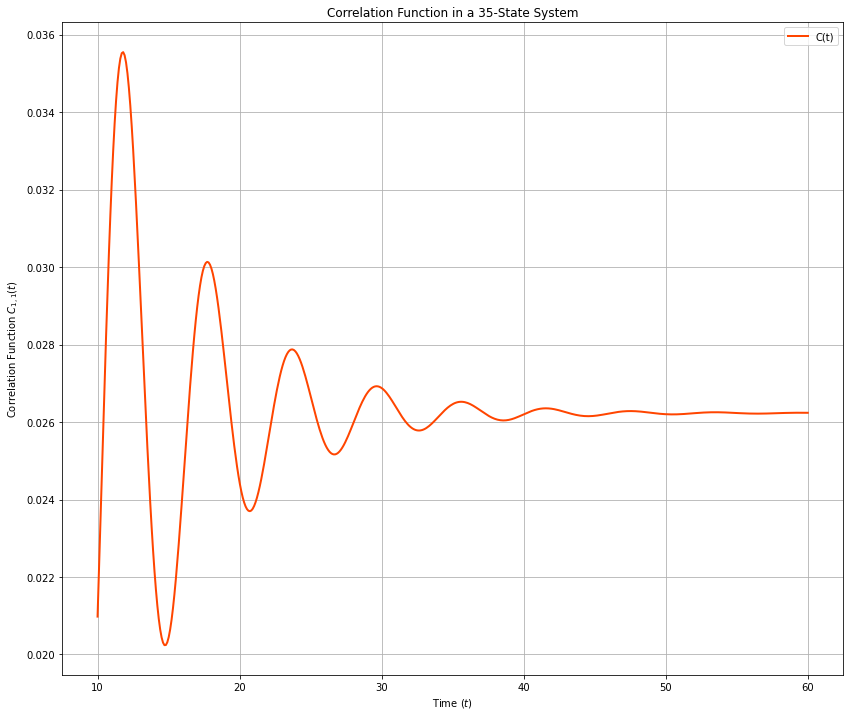

In [92]:
num_states = str(x)

fig, ax = plt.subplots(figsize = (14, 12))
plt.plot(times, correlation_values, color = "orangered", linewidth=2, label='C(t)')
plt.xlabel(r'Time ($t$)')
plt.ylabel(r'Correlation Function $C_{1,1}(t)$')
plt.title('Correlation Function in a '+ num_states +'-State System')
plt.legend()
plt.grid()
plt.show()